In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt
import time


from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import CSVLogger
from tqdm import tqdm
from copy import deepcopy

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        aug1 = self.resize_transform(aug1)
        aug2 = self.resize_transform(aug2)

        return aug1, aug2

In [5]:
# Create the dataset
image_dir = "../.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())



In [6]:
# Check an example to ensure correct conversion
for (aug1, aug2) in train_loader:
    print(aug1.shape, aug2.shape, aug1.dtype)
    break

torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.994    Total estimated model params size (MB)


Epoch 47: 100%|██████████| 19/19 [00:34<00:00,  0.54it/s, v_num=59, train_loss_step=5.05e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0114, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.000579, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=48` reached.


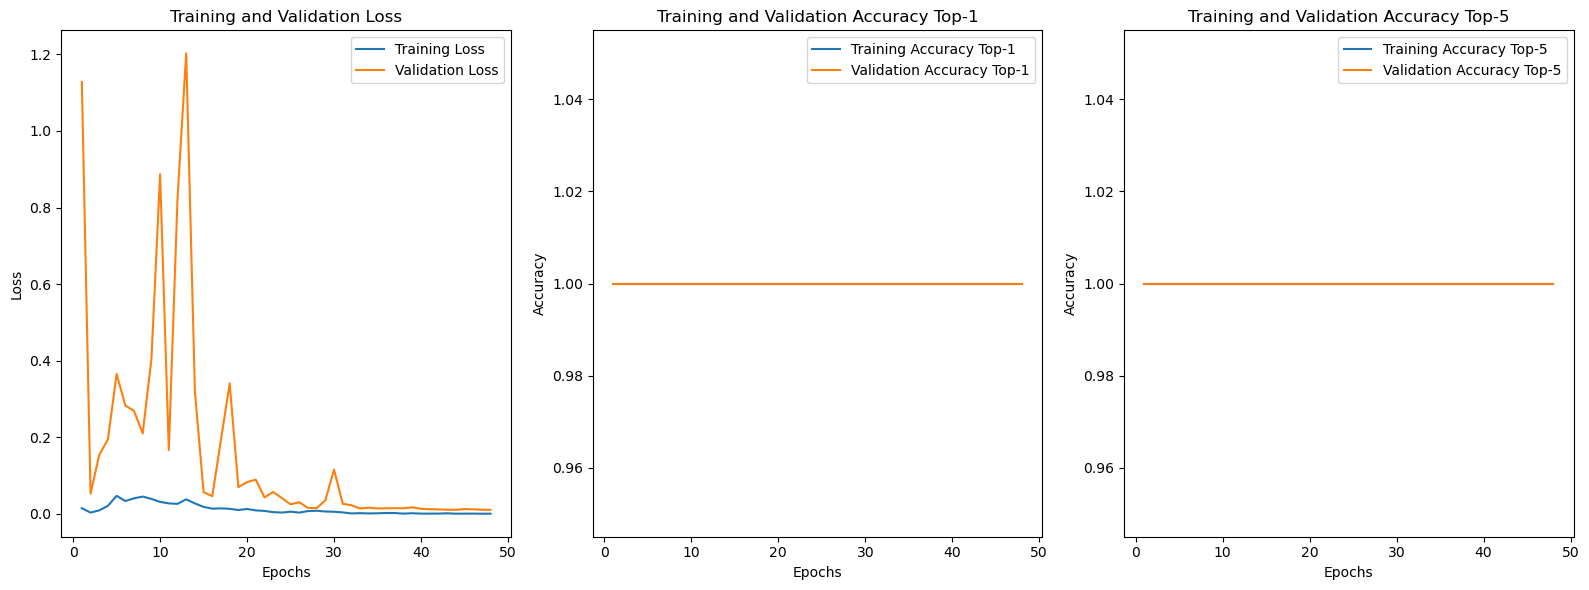

Epoch 47: 100%|██████████| 19/19 [00:36<00:00,  0.52it/s, v_num=59, train_loss_step=5.05e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0114, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.000579, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]


In [8]:
# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

    # Encode all images
        feats = self.convnet(imgs).to(self.device)
    # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

    # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
    # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                            cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll


    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')




# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []
        self.train_acc_top5 = []
        self.val_acc_top5 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())
        if 'train_acc_top5' in trainer.callback_metrics:
            self.train_acc_top5.append(trainer.callback_metrics['train_acc_top5'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())
        if 'val_acc_top5' in trainer.callback_metrics:
            self.val_acc_top5.append(trainer.callback_metrics['val_acc_top5'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), 
                      len(self.val_acc_top1), len(self.train_acc_top5), len(self.val_acc_top5))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]
        self.train_acc_top5 = self.train_acc_top5[:min_len]
        self.val_acc_top5 = self.val_acc_top5[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(16, 6))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_acc_top5, label='Training Accuracy Top-5')
        plt.plot(epochs, self.val_acc_top5, label='Validation Accuracy Top-5')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-5')

        plt.tight_layout()
        plt.show()



# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices= 'auto',
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])

    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=8, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=48)


# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')




# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices= 'auto',
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])

    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=32, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50)


Logistic

In [9]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels

# Directories for labeled data
image_dir = "/home/k54739/Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

In [10]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 1, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])


In [11]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        
        #print(f"Batch features shape: {batch_feats.shape}")
        #print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    #print(f"Features shape after concatenation: {feats.shape}")
    #print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [12]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


In [14]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=5):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [15]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        best_model_path = trainer.checkpoint_callback.best_model_path
        
        if best_model_path:
            print(f"Saving best model to {best_model_path}")
            model = LogisticRegression.load_from_checkpoint(best_model_path)
        else:
            print("No checkpoint found. Training completed without saving a checkpoint.")
            model = LogisticRegression(**kwargs)  # Reinitialize if no checkpoint saved

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result


In [17]:


# Train the logistic regression model
logreg_model, results = train_logreg(batch_size=8, train_feats_data=train_feats_simclr, test_feats_data=test_feats_simclr, 
                                     model_suffix="SimCLR", feature_dim=train_feats_simclr.tensors[0].shape[1], num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=50)

print(f"Train Accuracy: {results['train']}, Test Accuracy: {results['test']}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.5 K  | train
-----------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 78.48it/s, v_num=19] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 75.89it/s, v_num=19]
Saving best model to saved_models/simclr/LogisticRegression/lightning_logs/version_19/checkpoints/epoch=9-step=60.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 193.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 169.15it/s]
Train Accuracy: 0.9583333134651184, Test Accuracy: 1.0


Simclr just another way used (not important)

In [16]:
import os
import torch
import pytorch_lightning as pl
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        aug1 = self.resize_transform(aug1)
        aug2 = self.resize_transform(aug2)

        return aug1, aug2

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Train Accuracy')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top-1 Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        plt.show()

# Define the model and trainer
model = SimCLR(hidden_dim=128, lr=1e-3, temperature=0.1, weight_decay=1e-4, max_epochs=5)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_PATH,
    filename='best_model',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
plot_callback = PlotLossAccuracyCallback()

# Train the model
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback, lr_monitor, plot_callback],
    accelerator = 'gpu' if torch.cuda.is_available() else cpu
)

# Fit the model
trainer.fit(model, train_loader, val_loader)

# Plot the metrics
plot_callback.plot_metrics()

# Load the best checkpoint after training
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

# Ensure the best model is loaded for further use
model = SimCLR.load_from_checkpoint(best_model_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /home/k54739/lightning_logs
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/k54739/saved_models/simclr exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.994    Total estimated model params size (MB)


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 19/19 [00:26<00:00,  0.73it/s, v_num=0, train_loss_step=0.00136, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=1.430, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.399, train_acc_top1_epoch=0.998, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 0, global step 19: 'val_loss' reached 1.42672 (best 1.42672), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 1: 100%|██████████| 19/19 [00:30<00:00,  0.63it/s, v_num=0, train_loss_step=0.0704, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=2.280, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.212, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 1, global step 38: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 19/19 [00:28<00:00,  0.67it/s, v_num=0, train_loss_step=0.00146, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=1.560, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.179, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 2, global step 57: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 19/19 [00:28<00:00,  0.66it/s, v_num=0, train_loss_step=0.000935, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.324, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.117, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 3, global step 76: 'val_loss' reached 0.32446 (best 0.32446), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 4: 100%|██████████| 19/19 [00:28<00:00,  0.67it/s, v_num=0, train_loss_step=0.000764, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.101, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0894, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 4, global step 95: 'val_loss' reached 0.10053 (best 0.10053), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 5: 100%|██████████| 19/19 [00:30<00:00,  0.62it/s, v_num=0, train_loss_step=0.000277, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0887, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0499, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 5, global step 114: 'val_loss' reached 0.08870 (best 0.08870), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 6: 100%|██████████| 19/19 [00:31<00:00,  0.60it/s, v_num=0, train_loss_step=0.000283, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0729, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0491, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 6, global step 133: 'val_loss' reached 0.07294 (best 0.07294), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 7: 100%|██████████| 19/19 [00:32<00:00,  0.59it/s, v_num=0, train_loss_step=0.00102, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.188, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0451, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]  

Epoch 7, global step 152: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 19/19 [00:29<00:00,  0.63it/s, v_num=0, train_loss_step=0.000299, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.310, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0476, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 8, global step 171: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 19/19 [00:29<00:00,  0.64it/s, v_num=0, train_loss_step=0.00184, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.157, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0586, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 9, global step 190: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 19/19 [00:29<00:00,  0.65it/s, v_num=0, train_loss_step=0.000687, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.401, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0842, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 10, global step 209: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 19/19 [00:28<00:00,  0.67it/s, v_num=0, train_loss_step=0.0469, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=1.350, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0897, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]  

Epoch 11, global step 228: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 19/19 [00:29<00:00,  0.63it/s, v_num=0, train_loss_step=0.00543, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.293, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0709, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 12, global step 247: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 19/19 [00:30<00:00,  0.63it/s, v_num=0, train_loss_step=0.000951, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.355, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.080, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 13, global step 266: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 19/19 [00:30<00:00,  0.61it/s, v_num=0, train_loss_step=0.00158, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.109, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.065, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 14, global step 285: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 19/19 [00:29<00:00,  0.65it/s, v_num=0, train_loss_step=0.000742, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.114, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0531, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 15, global step 304: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 19/19 [00:30<00:00,  0.61it/s, v_num=0, train_loss_step=0.000428, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0801, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0371, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 16, global step 323: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 19/19 [00:30<00:00,  0.62it/s, v_num=0, train_loss_step=0.00012, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.123, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0362, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]  

Epoch 17, global step 342: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 19/19 [00:30<00:00,  0.62it/s, v_num=0, train_loss_step=0.000743, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.234, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0382, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 18, global step 361: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 19/19 [00:29<00:00,  0.64it/s, v_num=0, train_loss_step=0.000576, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.697, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0506, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 19, global step 380: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 19/19 [00:28<00:00,  0.66it/s, v_num=0, train_loss_step=0.000765, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.331, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.056, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 20, global step 399: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 19/19 [00:28<00:00,  0.66it/s, v_num=0, train_loss_step=0.0441, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.183, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0469, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 21, global step 418: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 19/19 [00:28<00:00,  0.67it/s, v_num=0, train_loss_step=0.0101, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.211, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0773, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 22, global step 437: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 19/19 [00:28<00:00,  0.67it/s, v_num=0, train_loss_step=0.000409, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.048, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.0609, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

Epoch 23, global step 456: 'val_loss' reached 0.04796 (best 0.04796), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 24: 100%|██████████| 19/19 [00:28<00:00,  0.66it/s, v_num=0, train_loss_step=0.000209, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.038, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.050, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000] 

Epoch 24, global step 475: 'val_loss' reached 0.03798 (best 0.03798), saving model to '/home/k54739/saved_models/simclr/best_model.ckpt' as top 1


Epoch 25:   0%|          | 0/19 [00:00<?, ?it/s, v_num=0, train_loss_step=0.000209, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.038, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.050, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]         

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73ea854ae0>
Traceback (most recent call last):
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1436, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1384, in _mark_worker_as_unavailable
    q.put(None)
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/multiprocessing/queues.py", line 94, in put
    self._start_thread()
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/multiprocessing/queues.py", line 192, in _start_thread
    self._thread.start()
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/threading.py", line 997, in